In [1]:
# !pip install torch-geometric
# !pip install networkx
# !pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
# !pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
# !pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
# !pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html

In [2]:
import pandas as pd
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.data import Data, DataLoader
import torch_geometric.nn as gnn

In [3]:
# Download data from https://www.kaggle.com/c/stanford-covid-vaccine/data

train_file = open("datasets/stanford-covid-vaccine/train.json", "r")
train_data_raw = train_file.read()
train_data = list(map(lambda l: json.loads(l), list(filter(lambda l: len(l) > 0, train_data_raw.split("\n")))))
train_file.close()

test_file = open("datasets/stanford-covid-vaccine/test.json", "r")
test_data_raw = test_file.read()
test_data = list(map(lambda l: json.loads(l), list(filter(lambda l: len(l) > 0, test_data_raw.split("\n")))))
test_file.close()

In [4]:
train_data[0].keys()

dict_keys(['index', 'id', 'sequence', 'structure', 'predicted_loop_type', 'signal_to_noise', 'SN_filter', 'seq_length', 'seq_scored', 'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C'])

In [5]:
signal_to_noise = list(map(lambda r: r["signal_to_noise"], train_data))

In [6]:
train_data[0]["sequence"]

'GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUAACUGGAAUAACCCAUACCAGCAGUUAGAGUUCGCUCUAACAAAAGAAACAACAACAACAAC'

In [7]:
train_data[0]["structure"]

'.....((((((.......)))).)).((.....((..((((((....))))))..)).....))....(((((((....))))))).....................'

In [8]:
train_data[0]["predicted_loop_type"]

'EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHHHSSSSSSIISSIIIIISSXXXXSSSSSSSHHHHSSSSSSSEEEEEEEEEEEEEEEEEEEEE'

In [9]:
train_data[0]["id"], len(train_data[0]["sequence"]), len(train_data[0]["structure"]), len(train_data[0]["predicted_loop_type"])

('id_001f94081', 107, 107, 107)

In [10]:
input_sequence = list(zip(train_data[0]["sequence"], train_data[0]["structure"], train_data[0]["predicted_loop_type"]))

In [11]:
len(input_sequence)

107

In [12]:
input_sequence[0], input_sequence[-1]

(('G', '.', 'E'), ('C', '.', 'E'))

In [13]:
output_sequence = list(zip(
    train_data[0]["reactivity"],
    train_data[0]["deg_Mg_pH10"],
    train_data[0]["deg_pH10"],
    train_data[0]["deg_Mg_50C"],
    train_data[0]["deg_50C"]))

In [14]:
output_sequence[0], output_sequence[-1]

((0.3297, 0.7556, 2.3375, 0.3581, 0.6382),
 (0.5731, 0.6898, 1.172, 0.4254, 0.8472))

In [15]:
evaluation_length = train_data[0]["seq_scored"]

In [16]:
def build_categorical_encoder(input_attribute_index_or_key, categories, total_dimensions, start_index, end_index):
    if not (end_index - start_index + 1 == len(categories)):
        raise Exception("Mismatch between number of categories and dimensions assigned.")
    def encoder(data_row, data_vector):
        if len(data_vector) != total_dimensions:
            raise Exception(f"Data vector is of size {len(data_vector)}, but should be of size {total_dimensions}.")
        
        category_index = categories.index(data_row[input_attribute_index_or_key])
        encoding_index = start_index + category_index
        data_vector[encoding_index] = 1
    
    return encoder

def build_continuous_encoder(input_attribute_index_or_key, total_dimensions, attribute_index):
    def encoder(data_row, data_vector):
        if len(data_vector) != total_dimensions:
            raise Exception(f"Data vector is of size {len(data_vector)}, but should be of size {total_dimensions}.")
        data_vector[attribute_index] = float(data_row[input_attribute_index_or_key])
    
    return encoder

def encode_data(rows, encoders, total_dimensions):
    encoded_rows = []
    for row in rows:
        encoded_row = [0] * total_dimensions
        for encoder in encoders:
            encoder(row, encoded_row)
        encoded_rows.append(encoded_row)
    
    return encoded_rows

In [17]:
total_dim_input = 11
total_dim_output = 5
sequence_classes = ["A", "G", "U", "C"]
structure_classes = ["(", ".", ")"]
predicted_loop_type_classes = ["S", "M", "I", "B", "H", "E", "X"]

sequence_encoder = build_categorical_encoder(0, sequence_classes, total_dim_input, 0, 3)
predicted_loop_encoder = build_categorical_encoder(2, predicted_loop_type_classes, total_dim_input, 4, 10)


data_encoders = [
    sequence_encoder,
    predicted_loop_encoder
]

In [18]:
encoded_input_sequence = encode_data(input_sequence, data_encoders, total_dim_input)

In [19]:
input_sequence[5]

('A', '(', 'S')

In [20]:
encoded_input_sequence[5]

[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

In [21]:
len(encoded_input_sequence)

107

In [22]:
torch.tensor(encoded_input_sequence, dtype=torch.float32).size()

torch.Size([107, 11])

In [23]:
def build_rna_graph_structure(input_sequence, target=None, target_errors=None, edge_probabilities=None):
    encoded_input_sequence = torch.tensor(
        encode_data(input_sequence, data_encoders, total_dim_input),
        dtype=torch.float32)
    edges = []
    node_features = []
    edge_features = []
    G = nx.Graph()
    stack = []
    prev_id = None
    for (node_id, (base, structure_class, predicted_loop_type)) in enumerate(input_sequence):
        G.add_node(node_id, base=base, predicted_loop_type=predicted_loop_type)
        if structure_class == "(":
            stack.append(node_id)
        elif structure_class == ")":
            neighbour_id = stack.pop()
            edges.append((node_id, neighbour_id))
            edges.append((neighbour_id, node_id))
            if edge_probabilities is not None:
                edge_probability = edge_probabilities[node_id, neighbour_id]
                edge_features.append([0, 1, 0, edge_probability])
                edge_features.append([0, 1, 0, edge_probability])
                G.add_edge(node_id, neighbour_id, feature=[0, 1, 0, edge_probability])
            else:
                edge_features.append([0, 1, 0, 1])
                edge_features.append([0, 1, 0, 1])
                G.add_edge(node_id, neighbour_id, feature=[0, 1])

        if prev_id is not None:
            edges.append((node_id, prev_id))
            edges.append((prev_id, node_id))
            edge_features.append([1, 0, 0, 1])
            edge_features.append([1, 0, 0, 1])
            G.add_edge(node_id, prev_id, feature=[1, 0])

        prev_id = node_id
    
    if edge_probabilities is not None:
        edge_set = set(edges)
        nnodes = len(G.nodes)
        for i in range(nnodes):
            for j in range(nnodes):
                edge_probability = edge_probabilities[i, j]
                if (i, j) not in edge_set and edge_probability > 0.0:
                    edges.append((i, j))
                    edges.append((j, i))
                    edge_set.add((i, j))
                    edge_set.add((j, i))
                    edge_features.append([0, 0, 1, edge_probability])
                    edge_features.append([0, 0, 1, edge_probability])
                    G.add_edge(node_id, prev_id, feature=[0, 0, 1, edge_probability])
            
    
    edge_index = torch.transpose(torch.tensor(edges, dtype=torch.long), 0, 1)
    edge_attr = torch.tensor(edge_features, dtype=torch.float32)
    
    if target is not None and target_errors is not None:
        weights = []
        for error_row in target_errors:
            weights_row = []
            for error in error_row:
                weights_row.append(1/(error + 1))
            weights.append(weights_row)
        target = torch.tensor(target, dtype=torch.float32)
        weights = torch.tensor(weights, dtype=torch.float32)
        graph_data = Data(x=encoded_input_sequence, edge_index=edge_index, y=target, weights=weights, edge_attr=edge_attr)
    elif target is not None:
        target = torch.tensor(target, dtype=torch.float32)
        graph_data = Data(x=encoded_input_sequence, edge_index=edge_index, edge_attr=edge_attr, y=target)
    else:
        graph_data = Data(x=encoded_input_sequence, edge_index=edge_index, edge_attr=edge_attr)
    
    # import pdb; pdb.set_trace()
    
    return G, graph_data

In [24]:
x = torch.tensor(encoded_input_sequence, dtype=torch.float32)

In [25]:
x.size()

torch.Size([107, 11])

In [26]:
G, graph_data = build_rna_graph_structure(input_sequence)

In [27]:
graph_data.x.size()

torch.Size([107, 11])

In [28]:
graph_data.num_features

11

In [29]:
graph_data.edge_index.size()

torch.Size([2, 258])

In [30]:
len(input_sequence)

107

In [31]:
graph_data.is_undirected()

tensor(True)

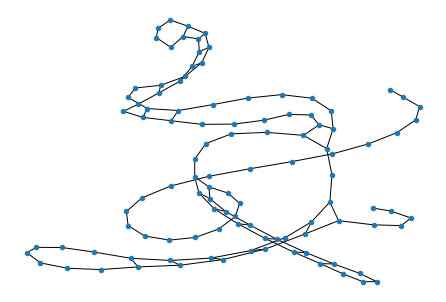

In [32]:
nx.draw(G, node_size=20)

In [33]:
G.nodes[0]

{'base': 'G', 'predicted_loop_type': 'E'}

In [34]:
G.edges.data()

EdgeDataView([(0, 1, {'feature': [1, 0]}), (1, 2, {'feature': [1, 0]}), (2, 3, {'feature': [1, 0]}), (3, 4, {'feature': [1, 0]}), (4, 5, {'feature': [1, 0]}), (5, 6, {'feature': [1, 0]}), (5, 24, {'feature': [0, 1]}), (6, 7, {'feature': [1, 0]}), (6, 23, {'feature': [0, 1]}), (7, 8, {'feature': [1, 0]}), (7, 21, {'feature': [0, 1]}), (8, 9, {'feature': [1, 0]}), (8, 20, {'feature': [0, 1]}), (9, 10, {'feature': [1, 0]}), (9, 19, {'feature': [0, 1]}), (10, 11, {'feature': [1, 0]}), (10, 18, {'feature': [0, 1]}), (11, 12, {'feature': [1, 0]}), (12, 13, {'feature': [1, 0]}), (13, 14, {'feature': [1, 0]}), (14, 15, {'feature': [1, 0]}), (15, 16, {'feature': [1, 0]}), (16, 17, {'feature': [1, 0]}), (17, 18, {'feature': [1, 0]}), (18, 19, {'feature': [1, 0]}), (19, 20, {'feature': [1, 0]}), (20, 21, {'feature': [1, 0]}), (21, 22, {'feature': [1, 0]}), (22, 23, {'feature': [1, 0]}), (23, 24, {'feature': [1, 0]}), (24, 25, {'feature': [1, 0]}), (25, 26, {'feature': [1, 0]}), (26, 27, {'feature

In [35]:
len(G.nodes), graph_data.x.size()

(107, torch.Size([107, 11]))

In [36]:
filtered_train_data = list(filter(lambda d: d["signal_to_noise"] >= 0.7, train_data))

graphs_train = []
dataset = []
for row in filtered_train_data:
    sequence_id = row["id"]
    edge_probabilities = np.load(f"datasets/stanford-covid-vaccine/bpps/{sequence_id}.npy")
    input_sequence = list(zip(row["sequence"], row["structure"], row["predicted_loop_type"]))
    target_sequence = list(zip(row["reactivity"], row["deg_Mg_pH10"], row["deg_pH10"], row["deg_Mg_50C"], row["deg_50C"]))
    target_sequence_errors = list(zip(row["reactivity_error"], row["deg_error_Mg_pH10"], row["deg_error_pH10"], row["deg_error_Mg_50C"], row["deg_error_50C"]))
    # target_sequence = list(zip(row["reactivity"], row["deg_Mg_pH10"], row["deg_Mg_50C"]))
    # target_sequence_errors = list(zip(row["reactivity_error"], row["deg_error_Mg_pH10"], row["deg_error_Mg_50C"]))
    G, graph_data = build_rna_graph_structure(input_sequence, target=target_sequence, target_errors=target_sequence_errors, edge_probabilities=edge_probabilities)
    dataset.append(graph_data)
    graphs_train.append(G)



graphs_test = []
testing_set = []
testing_sequence_id_to_dataset_map = dict()
for row in test_data:
    sequence_id = row["id"]
    edge_probabilities = np.load(f"datasets/stanford-covid-vaccine/bpps/{sequence_id}.npy")
    input_sequence = list(zip(row["sequence"], row["structure"], row["predicted_loop_type"]))
    G, graph_data = build_rna_graph_structure(input_sequence, edge_probabilities=edge_probabilities)
    testing_set.append(graph_data)
    graphs_test.append(G)
    testing_sequence_id_to_dataset_map[row["id"]] = graph_data


In [37]:
dataset[0]

Data(edge_attr=[1244, 4], edge_index=[2, 1244], weights=[68, 5], x=[107, 11], y=[68, 5])

In [38]:
random.shuffle(dataset)

training = dataset[:int(len(dataset) * 0.8)]
evaluation = dataset[int(len(dataset) * 0.8):]

In [39]:
len(training), len(evaluation), len(testing_set)

(1734, 434, 3634)

In [41]:
batch_size_train = 31
batch_size_test = 318
number_of_epochs = 100
batch_size_submission = 158
# batch_size_train = 16
# batch_size_test = 480
# number_of_epochs = 100
# batch_size_train = 34
# batch_size_test = 434
# number_of_epochs = 100

In [42]:
training[0]

Data(edge_attr=[1948, 4], edge_index=[2, 1948], weights=[68, 5], x=[107, 11], y=[68, 5])

In [43]:
train_loader = DataLoader(training, batch_size=batch_size_train)
test_loader = DataLoader(evaluation, batch_size=batch_size_test)
submission_loader = DataLoader(testing_set, batch_size=batch_size_submission)
test_batches = list(test_loader)

In [44]:
test_batch = test_batches[0]

In [45]:
class RNAGCNN(nn.Module):
    
    def __init__(self, node_features_dim=None, node_embedding_dim=None, node_output_features_dim=None):
        super(RNAGCNN, self).__init__()
        
        # self.conv1 = GCNConv(node_features_dim, node_embedding_dim)
        # conv_layers = [GCNConv(node_features_dim, hidden_dim)]
        conv_layers = []
        for i in range(node_features_dim - 1, node_embedding_dim - 1, -1):
            conv_layers.append(gnn.GCNConv(i + 1, i))
        self.conv_layers = nn.Sequential(*conv_layers)
        self.linear1 = nn.Linear(node_embedding_dim, node_embedding_dim + 5)
        self.linear2 = nn.Linear(node_embedding_dim + 5, node_output_features_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv_layer in self.conv_layers:
            x = conv_layer(x, edge_index)
            x = F.relu(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        
        return x


class RNAGenConv(nn.Module):
    
    def __init__(self, node_features_dim=None, node_embedding_dim=None, node_output_features_dim=None):
        super(RNAGenConv, self).__init__()
        
        self.conv_layer = gnn.GENConv(in_channels=node_features_dim, out_channels=node_embedding_dim)
        self.dropout = nn.Dropout(p=0.1)
        self.linear1 = nn.Linear(node_embedding_dim, node_embedding_dim + 5)
        self.linear2 = nn.Linear(node_embedding_dim + 5, node_output_features_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv_layer(x, edge_index)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        
        return x


class DeepRNAGenConv(nn.Module):
    
    def __init__(self, node_features_dim=None, node_embedding_dim=None, num_layers=None, node_output_features_dim=None, convolution_dropout=0.1, dense_dropout=0.0):
        super(DeepRNAGenConv, self).__init__()
        
        self.node_encoder = nn.Linear(node_features_dim, node_embedding_dim)
        
        self.gcn_layers = nn.ModuleList()
        for i in range(num_layers):
            convolution = gnn.GENConv(in_channels=node_embedding_dim, out_channels=node_embedding_dim)
            norm = nn.LayerNorm(node_embedding_dim)
            activation = nn.ReLU()
            layer = gnn.DeepGCNLayer(conv=convolution, norm=norm, act=activation, dropout=convolution_dropout)
            self.gcn_layers.append(layer)

        self.dropout = nn.Dropout(p=dense_dropout)
        self.decoder = nn.Linear(node_embedding_dim, node_output_features_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.node_encoder(x)
        for layer in self.gcn_layers:
            x = layer(x, edge_index)
        
        x = self.dropout(x)
        x = self.decoder(x)
        
        return x


class DeepRNAGenConvWithEdges(nn.Module):
    
    def __init__(self, node_features_dim=None, edge_attribute_size=None, node_embedding_dim=None, num_layers=None, node_output_features_dim=None, convolution_dropout=0.1, dense_dropout=0.0):
        super(DeepRNAGenConvWithEdges, self).__init__()
        
        self.node_encoder = nn.Linear(node_features_dim, node_embedding_dim)
        self.edge_encoder = nn.Linear(edge_attribute_size, node_embedding_dim)
        
        self.gcn_layers = nn.ModuleList()
        for i in range(num_layers):
            convolution = gnn.GENConv(in_channels=node_embedding_dim, out_channels=node_embedding_dim)
            norm = nn.LayerNorm(node_embedding_dim)
            activation = nn.ReLU()
            layer = gnn.DeepGCNLayer(conv=convolution, norm=norm, act=activation, dropout=convolution_dropout)
            self.gcn_layers.append(layer)

        self.dropout = nn.Dropout(p=dense_dropout)
        self.decoder = nn.Linear(node_embedding_dim, node_output_features_dim)
    
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)
        for layer in self.gcn_layers:
            x = layer(x, edge_index, edge_attr)
        
        x = self.dropout(x)
        x = self.decoder(x)
        
        return x


class DeepRNANNConvWithEdges(nn.Module):
    
    def __init__(self, node_features_dim=None, edge_attribute_size=None, node_embedding_dim=None, num_layers=None, node_output_features_dim=None, convolution_dropout=0.1, dense_dropout=0.0):
        super(DeepRNANNConvWithEdges, self).__init__()
        
        self.node_encoder = nn.Linear(node_features_dim, node_embedding_dim)
        self.edge_encoder = nn.Linear(edge_attribute_size, node_embedding_dim * node_embedding_dim)
        
        self.gcn_layers = nn.ModuleList()
        for i in range(num_layers):
            convolution = gnn.NNConv(in_channels=node_embedding_dim, out_channels=node_embedding_dim, nn=self.edge_encoder)
            norm = nn.LayerNorm(node_embedding_dim)
            activation = nn.ReLU()
            layer = gnn.DeepGCNLayer(conv=convolution, norm=norm, act=activation, dropout=convolution_dropout)
            self.gcn_layers.append(layer)

        self.dropout = nn.Dropout(p=dense_dropout)
        self.decoder = nn.Linear(node_embedding_dim, node_output_features_dim)
    
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.node_encoder(x)
        # edge_attr = self.edge_encoder(edge_attr)
        for layer in self.gcn_layers:
            x = layer(x, edge_index, edge_attr)
        
        x = self.dropout(x)
        x = self.decoder(x)
        
        return x


class DeeperGCN(torch.nn.Module):
    def __init__(self, node_features_dim=None, hidden_channels=None, num_layers=None, node_output_features_dim=None):
        super(DeeperGCN, self).__init__()

        self.node_encoder = nn.Linear(node_features_dim, hidden_channels)

        self.layers = nn.ModuleList()
        for i in range(1, num_layers + 1):
            conv = gnn.GENConv(hidden_channels, hidden_channels, aggr='softmax',
                           t=1.0, learn_t=True, num_layers=2, norm='layer')
            norm = nn.LayerNorm(hidden_channels, elementwise_affine=True)
            act = nn.ReLU(inplace=True)

            layer = gnn.DeepGCNLayer(conv, norm, act, block='res+', dropout=0.5,
                                     ckpt_grad=i % 3)
            self.layers.append(layer)

        self.lin = nn.Linear(hidden_channels, node_output_features_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.node_encoder(x)

        x = self.layers[0].conv(x, edge_index)

        for layer in self.layers[1:]:
            x = layer(x, edge_index)

        x = self.layers[0].act(self.layers[0].norm(x))
        x = F.dropout(x, p=0.2, training=self.training)

        return self.lin(x)

In [46]:
def weighted_mse_loss(output, target, weights=None):
    if weights is not None:
        weighted_sum_errors = weights * ((output - target)**2)
        mean_weighted_sum_errors = weighted_sum_errors.mean()
        return mean_weighted_sum_errors
    else:
        return F.mse_loss(output, target)

def unweighted_mse_loss(output, target, **kwargs):
    return F.mse_loss(output, target)

In [47]:
def batch_loss(batch_input, batch_output, batch_size, loss_function=None, eval_length=None):
    total_loss = torch.tensor(0.0).to("cuda")
    for i in range(batch_size):
        graph_output = batch_output[batch_input.batch == i]
        target = batch_input.y[(i * eval_length):((i + 1) * eval_length), :].to("cuda")
        weights = batch_input.weights[(i * eval_length):((i + 1) * eval_length), :].to("cuda")
        evaluation_nodes = target.size(0)
        graph_output_evaluation = graph_output[:evaluation_nodes, :]
        total_loss += loss_function(graph_output_evaluation, target, weights=weights)
    
    return total_loss

In [48]:
rna_gcnn = DeeperGCN(node_features_dim=total_dim_input, hidden_channels=96, num_layers=10, node_output_features_dim=5).cuda()
# rna_gcnn = RNAGenConv(node_features_dim=total_dim_input, node_embedding_dim=96, node_output_features_dim=5).cuda()
# rna_gcnn = DeepRNAGenConv(node_features_dim=total_dim_input, node_embedding_dim=90, num_layers=10, node_output_features_dim=5, convolution_dropout=0.5, dense_dropout=0.1).cuda()
# rna_gcnn = DeepRNAGenConvWithEdges(node_features_dim=total_dim_input, edge_attribute_size=4, node_embedding_dim=90, num_layers=10, node_output_features_dim=5, convolution_dropout=0.7, dense_dropout=0.1).cuda()
# rna_gcnn = DeepRNANNConvWithEdges(node_features_dim=total_dim_input, edge_attribute_size=4, node_embedding_dim=50, num_layers=4, node_output_features_dim=5, convolution_dropout=0.2, dense_dropout=0.1).cuda()

optimizer = optim.Adam(rna_gcnn.parameters(), lr=0.01)

In [49]:
train_counter = list(range(len(train_loader) * number_of_epochs))
train_losses = []
test_losses = []
test_counter = [i * len(train_loader) for i in range(number_of_epochs)]
for n in range(number_of_epochs):
    for batch_input in train_loader:
        rna_gcnn.zero_grad()
        batch_output = rna_gcnn(batch_input.to("cuda"))
        loss = batch_loss(batch_input, batch_output, batch_size_train, loss_function=unweighted_mse_loss, eval_length=evaluation_length) / batch_size_train
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        rna_gcnn.zero_grad()
        train_losses.append(torch.sqrt(loss).item())
    with torch.no_grad():
        batch_output_test = rna_gcnn(test_batch.to("cuda"))
        test_loss = batch_loss(test_batch, batch_output_test, batch_size_test, loss_function=unweighted_mse_loss, eval_length=evaluation_length) / batch_size_test
        test_losses.append(torch.sqrt(test_loss).item())
            

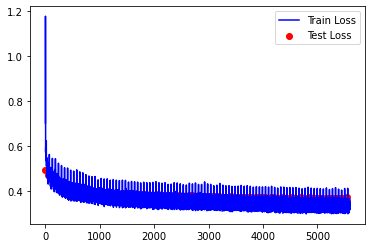

In [50]:
fig, ax = plt.subplots()
ax.plot(train_counter, train_losses, color="b", label="Train Loss")
ax.scatter(test_counter, test_losses, color="red", label="Test Loss")
leg = ax.legend()

In [51]:
min(train_losses), min(test_losses)

(0.2977384626865387, 0.36742594838142395)

In [52]:
rna_gcnn.eval()

DeeperGCN(
  (node_encoder): Linear(in_features=11, out_features=96, bias=True)
  (layers): ModuleList(
    (0): DeepGCNLayer(block=res+)
    (1): DeepGCNLayer(block=res+)
    (2): DeepGCNLayer(block=res+)
    (3): DeepGCNLayer(block=res+)
    (4): DeepGCNLayer(block=res+)
    (5): DeepGCNLayer(block=res+)
    (6): DeepGCNLayer(block=res+)
    (7): DeepGCNLayer(block=res+)
    (8): DeepGCNLayer(block=res+)
    (9): DeepGCNLayer(block=res+)
  )
  (lin): Linear(in_features=96, out_features=5, bias=True)
)

In [53]:
output_header = 'id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C'

In [54]:
output_lines = [output_header]
for sequence_id, graph_dataset in testing_sequence_id_to_dataset_map.items():
    output = rna_gcnn(graph_dataset.to("cuda"))
    output = output.to("cpu")
    seq_length = output.size(0)
    for i in range(seq_length):
        seq_id_pos = f"{sequence_id}_{i}"
        seq_id_pos_entry = list(map(lambda num: str(num), output[i,:].tolist()))
        submission_line_entries = [seq_id_pos] + seq_id_pos_entry
        submission_line = ",".join(submission_line_entries)
        output_lines.append(submission_line)

In [55]:
submission_data = "\n".join(output_lines)

In [56]:
submission_file = open("submission-gcn.csv", "w")
submission_file.write(submission_data)
submission_file.close()